In [3]:
%load_ext autoreload
from quantifier import *
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [26]:
%autoreload 2
lbdfHT,linfodf=readin(configfname="g1.yml")

4	E3	122184.0	78.6	66.8	21.0	0.014 +/- 0.003	0.23 +/- 0.05	0.018 +/- 0.004
5	E5	232452.0	27.6	31.3	7.0	0.026 +/- 0.008	1.24 +/- 0.40	0.034 +/- 0.011
6	E7	152856.0	39.4	33.7	12.0	0.018 +/- 0.005	0.49 +/- 0.13	0.019 +/- 0.005
7	E8	249660.0	35.3	27.4	7.0	0.029 +/- 0.007	1.39 +/- 0.33	0.049 +/- 0.011
8	F1	264456.0	56.5	44.3	12.0	0.030 +/- 0.009	0.83 +/- 0.25	0.047 +/- 0.014
9	F2	115236.0	73.7	60.1	7.0	0.013 +/- 0.005	0.60 +/- 0.23	0.044 +/- 0.017
10	F3	336312.0	64.8	53.7	18.0	0.039 +/- 0.011	0.71 +/- 0.20	0.046 +/- 0.013
11	F6	338148.0	66.6	55.2	22.0	0.040 +/- 0.009	0.60 +/- 0.14	0.040 +/- 0.009
12	G1	156852.0	100.3	82.4	20.0	0.018 +/- 0.005	0.30 +/- 0.08	0.030 +/- 0.008
13	G2	331380.0	75.2	60.9	20.0	0.039 +/- 0.009	0.65 +/- 0.14	0.049 +/- 0.011
14	G4	190656.0	82.4	72.1	10.0	0.022 +/- 0.006	0.73 +/- 0.20	0.060 +/- 0.017
15	G5	210636.0	92.6	76.0	12.0	0.025 +/- 0.005	0.69 +/- 0.15	0.064 +/- 0.014
16	G7	289872.0	80.1	63.2	31.0	0.034 +/- 0.008	0.36 +/- 0.09	0.029 +/- 0.007
17	H1	448992.0	38.6	

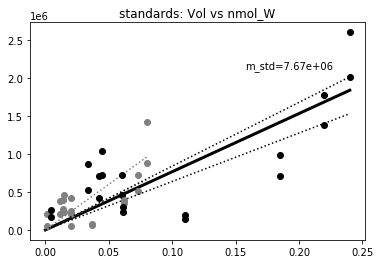

In [27]:
def propo(x,m):
    return m*x

pplus_ngin10uLHT={250:360,150:210,100:15,75:660,50:733.3,37:220,25:800,20:150,15:200,10:140}
pplus_winseqHT={250:51,150:29,100:19,75:14,50:10,37:5,25:5,20:3,15:3,10:2}
mindetectable_intensity=80000

#start by getting calibration curve from relevant lanes
std_dfs_=[]
stdlanedf=linfodf[linfodf['sample']=='std']
for std in stdlanedf.index:
    lnum=stdlanedf['lane'].at[std]
    load_uL=stdlanedf['volume'].at[std]
    curdf=lbdfHT[lnum]
    std_dfs_.append(curdf)

    curdf['ng']=[np.nan for x in curdf.index]
    curdf['nmol']=[np.nan for x in curdf.index]
    curdf['nmolW']=[np.nan for x in curdf.index]
    for bidx in curdf.index:
        ngPer10uL=pplus_ngin10uLHT[curdf['Mol. Wt. (KDa)'].at[bidx]]
        ng_loaded=ngPer10uL*(load_uL/10)
        curdf['ng'].at[bidx]=ng_loaded
        curdf['nmol'].at[bidx]=ng_loaded/(curdf['Mol. Wt. (KDa)'].at[bidx]*1e3)
        curdf['nmolW'].at[bidx]=pplus_winseqHT[curdf['Mol. Wt. (KDa)'].at[bidx]]*curdf['nmol'].at[bidx]
comp_stdXA_=[std_df['nmolW'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_stdYA_=[std_df['Volume (Int)'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_std_linregress=curve_fit(propo,comp_stdXA_,comp_stdYA_)
comp_std_slope=comp_std_linregress[0][0]
comp_stdAdjYA_=[std_df['Adj. Volume (Int)'].at[x] for std_df in std_dfs_ for x in std_df.index]
comp_std_linregressAdj=curve_fit(propo,comp_stdXA_,comp_stdAdjYA_)
comp_std_slopeAdj=comp_std_linregressAdj[0][0]
#comp_std_linregress=linregress(comp_stdXA_,comp_stdYA_)

###this slope is 
comp_std_fitXA_=np.array([0,max(comp_stdXA_)])
comp_std_fitYA_=np.array([0,comp_std_fitXA_[1]*comp_std_slope])
#comp_std_fitYA_+=comp_std_linregress.intercept

fig,ax_std=plt.subplots()
ax_std.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
ax_std.yaxis.get_major_formatter().set_powerlimits((0,1))
ax_std.set_title("standards: Vol vs nmol_W")
#plt.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
std_xmax=ax_std.get_xlim()
std_ymiax=ax_std.get_ylim()
plt.text(0.9*ax_std.get_xlim()[1],1.1*ax_std.get_ylim()[1],'m_std={:.2e}'.format(comp_std_slope),ha='right')

for std_df in std_dfs_:
    stdvol=linfodf.loc[linfodf['lane']==std_df['Lane'].iat[0]]['volume'].values[0]
    kwHT={'c':'black'}
    if stdvol<10:
        kwHT['c']='gray'
    plt.plot('nmolW','Volume (Int)',data=std_df,marker='o',ls=' ',**kwHT)
    cur_linregress=curve_fit(propo,std_df['nmolW'].values,std_df['Volume (Int)'].values)#,data=std_df)
    cur_std_fitXA_=np.array([0,max(std_df['nmolW'].values)])
    cur_std_fitYA_=np.array([0,cur_std_fitXA_[1]*cur_linregress[0][0]])
    plt.plot(cur_std_fitXA_,cur_std_fitYA_,**kwHT,ls=':')
#how many other lanes are there?
qinfodf=linfodf[linfodf['sample']!='std']
num_lanes=qinfodf.shape[0]
#fig,ax_=plt.subplots(nrows=int(num_lanes/3)+1,ncols=3,figsize=(25,40))
#table columns:lane#, label,nmolW,uM,mgmL,mw-indep,mw-gelcalc
trows_=[]
for lidx,lindex in enumerate(qinfodf.index):
    #ax=ax_[int(lidx/3),lidx%3]
    #ax.plot(comp_std_fitXA_,comp_std_fitYA_,c='black',lw=3)
    lnum=qinfodf['lane'].at[lindex]
    load_uL=qinfodf['volume'].at[lindex]
    if lnum in lbdfHT.keys():
        curdf=lbdfHT[lnum]
    else:
        #do a min thing here:
        nmolW_max=mindetectable_intensity/comp_std_slope
        nmol_max=nmolW_max/qinfodf['wcount'].at[lindex]
        pconc_max=1e6*nmol_max*1e-3/qinfodf['volume'].at[lindex]
        mgmL_max=1e-6*pconc_max*(qinfodf['mw'].at[lindex]*1e3)
        print('no band detected in lane {0} (sid {1})'.format(lnum,qinfodf['sample'].at[lindex]))
        trow=[]
        trow.append("{}".format(lnum))
        trow.append("{}".format(qinfodf['sample'].at[lindex]))
        trow.append("<{}".format(mindetectable_intensity))
        trow.append("{:.1f}".format(qinfodf['mw'].at[lindex]))
        trow.append("nd")
        trow.append("{}".format(qinfodf['wcount'].at[lindex]))
        trow.append("<{0:.2f}".format(nmolW_max))
        trow.append("<{0:.1f}".format(pconc_max))
        trow.append("<{0:.2f}".format(mgmL_max))
        trows_.append(trow)
        continue
        
    curdf['nmolW']=[np.nan for x in curdf.index]
    curdf['nmol']=[np.nan for x in curdf.index]
    curdf['pconc']=[np.nan for x in curdf.index] #conc in uM
    curdf['mgmL']=[np.nan for x in curdf.index]
    curdf['nmolW_AdjVol']=[np.nan for x in curdf.index]
    curdf['nmol_AdjVol']=[np.nan for x in curdf.index]
    curdf['pconc_AdjVol']=[np.nan for x in curdf.index] #conc in uM
    curdf['mgmL_AdjVol']=[np.nan for x in curdf.index]
    for bidx in curdf.index:
        curdf['nmolW']=curdf['Volume (Int)'].at[bidx]/comp_std_slope
        curdf['nmol']=curdf['nmolW'].at[bidx]/qinfodf['wcount'].at[lindex]
        curdf['pconc']=1e6*curdf['nmol'].at[bidx]*1e-3/qinfodf['volume'].at[lindex]
        curdf['mgmL']=1e-6*curdf['pconc']*(qinfodf['mw'].at[lindex]*1e3)
        
        curdf['nmolW_AdjVol']=curdf['Adj. Volume (Int)'].at[bidx]/comp_std_slope
        curdf['nmol_AdjVol']=curdf['nmolW_AdjVol'].at[bidx]/qinfodf['wcount'].at[lindex]
        curdf['pconc_AdjVol']=1e6*curdf['nmol_AdjVol'].at[bidx]*1e-3/qinfodf['volume'].at[lindex]
        curdf['mgmL_AdjVol']=1e-6*curdf['pconc_AdjVol'].at[bidx]*(qinfodf['mw'].at[lindex]*1e3)
        trow=[]
        trow.append("{}".format(lnum))
        trow.append("{}".format(qinfodf['sample'].at[lindex]))
        trow.append("{}".format(curdf['Volume (Int)'].at[bidx]))
        trow.append("{:.1f}".format(qinfodf['mw'].at[lindex]))
        trow.append("{:.1f}".format(curdf['Mol. Wt. (KDa)'].at[bidx]))
        trow.append("{}".format(qinfodf['wcount'].at[lindex]))
        
        est_nmolW=0.75*curdf['nmolW'].at[bidx]+0.25*curdf['nmolW_AdjVol'].at[bidx]
        est_nmolW_err=0.5*(abs(curdf['nmolW'].at[bidx]-curdf['nmolW_AdjVol'].at[bidx]))
        est_nmolW_err=max(est_nmolW_err,0.1*est_nmolW)
        trow.append("{0:.3f} +/- {1:.3f}".format(est_nmolW,est_nmolW_err))
        
        est_uM=1e6*(est_nmolW/qinfodf['wcount'].at[lindex])*1e-3/qinfodf['volume'].at[lindex]
        est_uM_err=1e6*(est_nmolW_err/qinfodf['wcount'].at[lindex])*1e-3/qinfodf['volume'].at[lindex]
        trow.append("{0:.2f} +/- {1:.2f}".format(est_uM,est_uM_err))
        
        est_mgmL=1e-6*est_uM*(qinfodf['mw'].at[lindex]*1e3)
        est_mgmL_err=1e-6*est_uM_err*(qinfodf['mw'].at[lindex]*1e3)
        trow.append("{0:.3f} +/- {1:.3f}".format(est_mgmL,est_mgmL_err))
        
        trows_.append(trow)
for trow in trows_:
    rowstr=''
    for e in trow[:-1]:
        rowstr+=e+'\t'
    rowstr+=trow[-1]
    print(rowstr)
        #lane,label,volume,mw(indep),mw(gcalc),nmolW,uM,mgmL
        #ax.plot('nmolW','Volume (Int)',data=curdf,c='black',marker='o',ls=' ')
    
        #print(lnum,curdf['pconc'].at[bidx],curdf['pconc_AdjVol'].at[bidx],curdf['mgmL'].at[bidx],curdf['mgmL_AdjVol'].at[bidx])